In [43]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 400)
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV

import time
import warnings
warnings.filterwarnings('ignore')


from sklearn.utils import resample
from sklearn import preprocessing
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.decomposition import PCA


In [44]:
train_id_imputed = pd.read_csv("train_id_imputed.csv", index_col = 0)
train_tran_imputed = pd.read_csv("train_tran_imputed.csv", index_col = 0)
y_train = pd.read_csv("y_train.csv")

In [45]:
# Memory Reduction

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    
    return df

In [46]:
%%time
#Memory reduction for train dataset
# reduce_mem_usage2(train_tran)
# reduce_mem_usage2(train_id)
reduce_mem_usage(train_tran_imputed)
reduce_mem_usage(train_id_imputed)
reduce_mem_usage(y_train)

Memory usage of dataframe is 1013.73 MB
Memory usage after optimization is: 270.90 MB
Decreased by 73.3%
Memory usage of dataframe is 34.11 MB
Memory usage after optimization is: 8.09 MB
Decreased by 76.3%
Memory usage of dataframe is 4.51 MB
Memory usage after optimization is: 0.56 MB
Decreased by 87.5%
Wall time: 33.6 s


In [47]:
#Garbage Collection
import gc
gc.collect()

31

In [48]:
print(train_tran_imputed.shape)
print(train_id_imputed.shape)
print(y_train.shape)

(590540, 224)
(144233, 30)
(590540, 1)


In [49]:
train_tran_imputed.sample(5)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3554159,15031353,57.9375,W,5290,268.0,150.0,visa,166.0,debit,469.0,87.0,2.0,gmail.com,5.0,5.0,0.0,0.0,1.0,3.0,0.0,0.0,3.0,0.0,3.0,0.0,25.0,5.0,396.0,396.0,12.0,396.0,12.0,50.0,415.0,396.0,T,T,T,-1,-1,F,-1,-1,-1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,67.949997,0.000000,0.0000,67.9375,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,67.949997,0.000000,0.0000,67.9375,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
3356079,9168736,52.9375,W,9485,111.0,150.0,visa,226.0,debit,315.0,87.0,-1.0,gmail.com,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,1.0,5.0,5.0,2.0,4.0,2.0,4.0,0.0,4.0,T,F,F,-1,-1,F,F,F,F,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,3.0,0.0,2.0,0.0,2.0,1.0,2.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,100.900002,100.900002,0.0000,100.8750,0.0,100.8750,47.9375,100.8750,100.8750,0.0,0.0,0.0,0.0,0.0,0.0
3465099,12407588,107.9375,W,14259,111.0,150.0,visa,226.0,debit,330.0,87.0,10.0,hotmail.es,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,T,T,T,-1,-1,T,F,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [50]:
train_id_imputed.sample(5)

,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3122092,-40.0,134493.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,100.0000,NotFound,18.0,-1.0,New,NotFound,225.0,266.0,595.0,New,NotFound,-1,chrome 59.0 for android,-1.0,-1,-1,F,F,T,T,mobile,ALE-L23 Build/HuaweiALE-L23
3478643,-5.0,72221.0,-1.0,-1.0,0.0,-11.0,-1.0,-1.0,95.0625,NotFound,52.0,-1.0,New,NotFound,225.0,266.0,325.0,Found,Found,-1,firefox 59.0,-1.0,-1,-1,F,F,T,F,desktop,Windows
3112667,-5.0,136179.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,100.0000,NotFound,52.0,-480.0,Found,NotFound,166.0,193.0,222.0,Found,NotFound,Windows 10,chrome 63.0,24.0,1600x900,match_status:2,T,F,T,F,desktop,Windows
3526880,-5.0,64305.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,100.0000,NotFound,64.0,-360.0,New,NotFound,166.0,215.0,333.0,New,NotFound,Mac OS X 10_13_4,chrome 66.0,24.0,2560x1600,match_status:2,T,F,T,F,desktop,MacOS
3096051,-20.0,159204.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0000,NotFound,52.0,-1.0,Found,Found,225.0,290.0,401.0,Found,Found,-1,chrome 63.0,-1.0,-1,-1,F,F,T,T,desktop,Windows


In [51]:
#Target
y_train.sample(5)

,isFraud
458397,0
46862,0
246267,0
347273,0
383924,0


### <font color = red>Data Imbalalnce</font>

Text(0.5, 1.0, 'Target Variable Count')

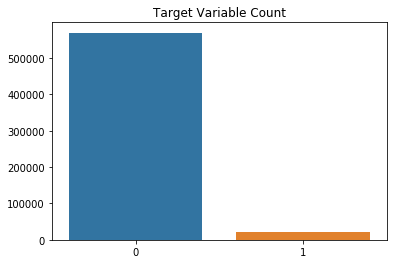

In [52]:
x = y_train['isFraud'].value_counts().values
sns.barplot([0,1], x)
plt.title('Target Variable Count')

The above distribution clearely implies data imbalance.
Now, lets find different methods to solve it.

In [53]:
#Initally let's combine both transaction & identification tables
train = train_tran_imputed.merge(train_id_imputed, how='left', left_index=True, right_index=True)

In [54]:
train.sample(5)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3339564,8705979,1220.000000,W,9500,321.0,150.0,visa,226.0,debit,330.0,87.0,56.0,aol.com,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0,0.0,8.0,2.0,564.0,564.0,72.0,0.0,-1.0,536.0,520.0,564.0,T,T,T,M0,F,F,F,F,F,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3306622,7944191,108.937500,W,7005,111.0,150.0,visa,226.0,debit,310.0,87.0,7.0,outlook.com,2.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,3.0,2.0,17.0,17.0,17.0,330.0,17.0,330.0,17.0,17.0,T,T,T,-1,-1,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,68.949997,0.0,0.0,68.9375,0.0,0.0,68.9375,68.9375,68.9375,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3095559,2144431,100.000000,R,6019,583.0,150.0,visa,226.0,credit,299.0,87.0,-1.0,att.net,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.

In [55]:
train.shape

(590540, 254)

In [56]:
train.dtypes

TransactionDT        int32
TransactionAmt     float16
ProductCD         category
card1                int16
card2              float16
card3              float16
card4             category
card5              float16
card6             category
addr1              float16
addr2              float16
dist1              float16
P_emaildomain     category
C1                 float16
C2                 float16
C3                 float16
C4                 float16
C5                 float16
C6                 float16
C7                 float16
C8                 float16
C9                 float16
C10                float16
C11                float16
C12                float16
C13                float16
C14                float16
D1                 float16
D2                 float16
D3                 float16
D4                 float16
D5                 float16
D10                float16
D11                float16
D15                float16
M1                category
M2                category
M

In [57]:
train_cat = train.select_dtypes(include=['category'])
train_num = train.select_dtypes(exclude=['category'])
train_cat = train_cat.astype(object)

In [58]:
train = pd.concat([train_num,train_cat], axis=1)

In [59]:
%%time
#Imputing NAN for newly formed df
train = train.fillna('-1')

Wall time: 1min 22s


In [60]:
train.sample(5)

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_13,id_14,id_17,id_19,id_20,id_32,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3052566,1470319,75.000,12779,100.0,150.0,226.0,337.00,87.0,-1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.000000,0.0,0.00,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-40.0,11420.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,100.0,41.0,-300.0,166.0,374.0,254.0,32.0,S,visa,credit,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,NotFound,New,NotFound,New,NotFound,iOS 10.3.3,mobile safari generic,2048x1536,match_status:2,T,F,T,T,mobile,iOS Device
3408588,10683534,59.000,3148,111.0,150.0,226.0,433.00,87.0,210.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,17.0,1.0,441.0,441.0,28.0,509.0,28.0,509.0,487.0,509.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,59.000000,0.000000,0.0,59.00,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,59.000000,0.000000,0.0,59.00,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W,visa,debit,yahoo.com,T,T,T,M1,F,F,F,F,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3236025,5938896,39.000,16075,514.0,150.0,102.0,272.00,87.0,12.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,26.0,1.0,165.0,165.0,1.0,-1.0,-1.0,165.0,151.0,165.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,

In [61]:
#Splitting train & Validation sets:

X_train,X_test,y_train,y_test=train_test_split(train , y_train, test_size=.2, random_state=1)

In [62]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(472432, 254)
(118108, 254)
(472432, 1)
(118108, 1)


In [63]:
#Oversampling Minority classes

X=pd.concat([X_train,y_train],axis=1)

not_fraud=X[X.isFraud==0]
fraud=X[X.isFraud==1]

fraud_upsampled = resample(fraud, replace=True, n_samples=len(not_fraud), random_state=27)

#combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled.isFraud.value_counts()


1.0    455903
0.0    455903
Name: isFraud, dtype: int64

Text(0, 0.5, 'count')

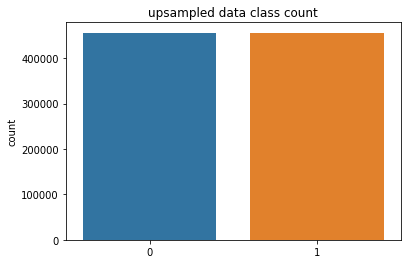

In [64]:
y=upsampled.isFraud.value_counts()
sns.barplot(y=y,x=[0,1])
plt.title('upsampled data class count')
plt.ylabel('count')

In [23]:
#!pip install imblearn

In [24]:
X_train.isnull().sum()

TransactionDT          0
TransactionAmt         0
card1                  0
card2                  0
card3                  0
card5                  0
addr1                  0
addr2                  0
dist1                  0
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                     0
D2                     0
D3                     0
D4                     0
D5                     0
D10                    0
D11                    0
D15                    0
V1                     0
V2                     0
V3                     0
V4                     0
V5                     0
V6                     0
V7                     0
V8                     0
V9                     0


In [1]:
# #Oversampling: SMOTE

# # %%time
# import imblearn
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(ratio='minority')
# n= 1000
# X_sm, y_sm = smote.fit_sample(X_train[:n], y_train[:n])

# plot_2d_space(X_sm, y_sm,X,y, 'SMOTE over-sampling')

### <font color=red>PCA [Dimensionality Reduction]</font>

In [65]:
# Label Encoding
from sklearn.preprocessing import OneHotEncoder
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        #lbl = preprocessing.OneHotEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))  

In [66]:
print(X_train.shape)
print(X_test.shape)

(472432, 254)
(118108, 254)


In [37]:
# %%time
# t0 = time.time()
# X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X)
# t1 = time.time()
# print("PCA took {:.2} s".format(t1 - t0))

In [38]:
# ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
# ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
# ax2.set_title('PCA', fontsize=14)

# ax2.grid(True)

# ax2.legend(handles=[blue_patch, red_patch])


### <font color=red>Modeling </font>

In [67]:
#Training

clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-1,
    random_state=2019
    #tree_method='gpu_hist'  # THE MAGICAL PARAMETER
)

In [399]:
%%time
clf.fit(X_train, y_train)

print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.98
Precision: 0.75
Recall: 0.45
Wall time: 1h 17min 21s


In [72]:
import lightgbm as lgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)


params = {
    'objective': 'binary:logistic',
    'max_depth' : 8,
    'silent': 1,
    'eta':1
}

num_rounds=5

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# %% [code]
train_labels = dtrain.get_label()
ratio= float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
params['scale_pos_weight'] = ratio



In [73]:
%%time

clf.fit(X_train, y_train)


print('Accuracy: {0:.2f}'.format(accuracy_score(y_test,y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_pred)))

NameError: name 'y_pred' is not defined

In [ ]:
%%time

params = {
    'objective': 'binary:logistic',
    'max_depth' : 8,
    'silent': 1,
    'eta':1
}
num_rounds=5

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# %% [code]
train_labels = dtrain.get_label()
ratio= float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
params['scale_pos_weight'] = ratio

# %% [code]
bst=xgb.train(params, dtrain, num_rounds)
y_test_preds = (bst.predict(dtest) > 0.5).astype('int')

pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

# %% [code]
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))